# Artificial Neural Network

The artificial neural network is an interconnected group of nodes inspired by biological neural networks that constitute the brain.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import joblib
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 800
svg_renderer.height = 500
pio.renderers.default = "svg"

## Model without oversample data

In [2]:
# Load the data
df = pd.read_csv('./../../data/engineered_data.csv')

In [3]:
# Drop the index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Before modelinng the data, it is necessary to split the data into training and testing set.

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

In [5]:
# Declare the logistic regression model
ann_clf = MLPClassifier(solver='adam', learning_rate='adaptive', early_stopping=True)

# Declare the grid paramters to be searched
ann_params = dict(
    hidden_layer_sizes = [(100,), (64, 128, ), (128, 64, )],
    activation = ['logistic', 'tanh', 'relu'],
    alpha = [0.0001, 0.001, 0.01, 0.1],
    max_iter = [200, 300, 400],

)

In [6]:
# Declare the gridsearch object
grid_search = GridSearchCV(ann_clf, ann_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result = grid_search.fit(X_train.values, y_train.values)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 2/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.937 total time=   2.5s
[CV 7/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.942 total time=   2.6s
[CV 4/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.950 total time=   2.9s
[CV 1/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.954 total time=   3.4s
[CV 3/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.957 total time=   3.6s
[CV 6/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.961 total time=   3.6s
[CV 5/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.958 total time=   3.7s
[CV 8/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_i

### Inferencing

In [7]:
# Get the best model parameters
print(f"Best score of {grid_search.best_score_} is achieved by using {grid_result.best_params_}")

Best score of 0.9571767300222584 is achieved by using {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (128, 64), 'max_iter': 400}


In [8]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test.values)
y_score = grid_search.predict_proba(X_test.values)[:, 1]

### Evaluation

In [9]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.9531468965157068


In [10]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

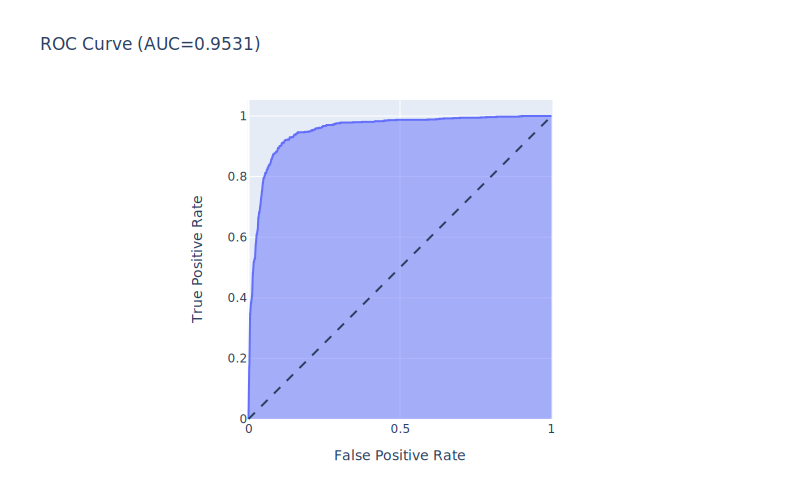

In [11]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

An AUC score of 0.88 is quite remarkable and it suggest that model is quite good in predicting whether a project on Kickstarter will be succecssful or not.

In [12]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

In [13]:
# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.79, 0.81)]

,fpr,tpr,threshold
170,0.049141,0.792474,0.647746
171,0.049618,0.792474,0.646578
172,0.049618,0.794755,0.645206
173,0.051050,0.794755,0.641181
174,0.051050,0.798176,0.636881
175,0.051527,0.798176,0.635136
176,0.051527,0.799316,0.633918
177,0.052004,0.799316,0.633026
178,0.052004,0.800456,0.631905
179,0.052481,0.800456,0.629496


From the above table, it is safe to assume the threshold value of 0.5 for classifying the observations.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



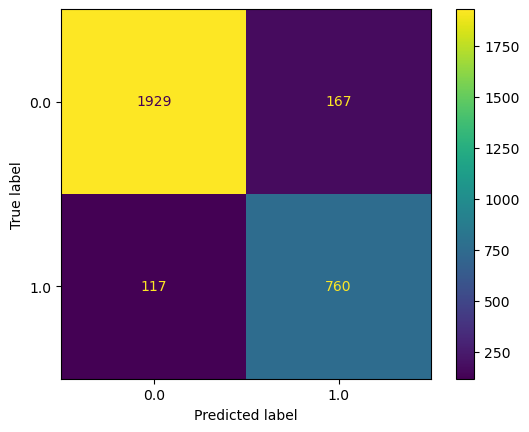

In [14]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_result, X_test, y_test)  

In [15]:
# Save the model
joblib.dump(grid_result, './../../data/models/ann.pkl')

['./../../data/models/ann.pkl']

## Model with oversample data

In [16]:
# Load the data
df = pd.read_csv('./../../data/engineered_data_oversampled.csv')

In [17]:
# Drop the index column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

In [19]:
# Declare the logistic regression model
ann_clf = MLPClassifier(solver='adam', learning_rate='adaptive', early_stopping=True)

# Declare the grid paramters to be searched
ann_params = dict(
    hidden_layer_sizes = [(100,), (64, 128, ), (128, 64, )],
    activation = ['logistic', 'tanh', 'relu'],
    alpha = [0.0001, 0.001, 0.01, 0.1],
    max_iter = [200, 300, 400]
)

In [20]:
# Declare the gridsearch object
grid_search = GridSearchCV(ann_clf, ann_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result = grid_search.fit(X_train.values, y_train.values)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 3/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.965 total time=   3.7s
[CV 1/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.970 total time=   4.6s
[CV 7/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.968 total time=   4.6s
[CV 5/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.961 total time=   4.7s
[CV 2/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.971 total time=   5.3s
[CV 6/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.971 total time=   7.0s
[CV 4/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=200;, score=0.966 total time=   7.1s
[CV 8/10] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_i

### Inferencing

In [21]:
# Get the best model parameters
print(f"Best score of {grid_result.best_score_} is achieved by using {grid_result.best_params_}")

Best score of 0.9724049843047465 is achieved by using {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'max_iter': 300}


In [22]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)[:, 1]

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



### Evaluation

In [23]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.9683070677874245


With the new oversampled data, there is a marginal improvement in the performance of the logistic regression algorithm.

In [24]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

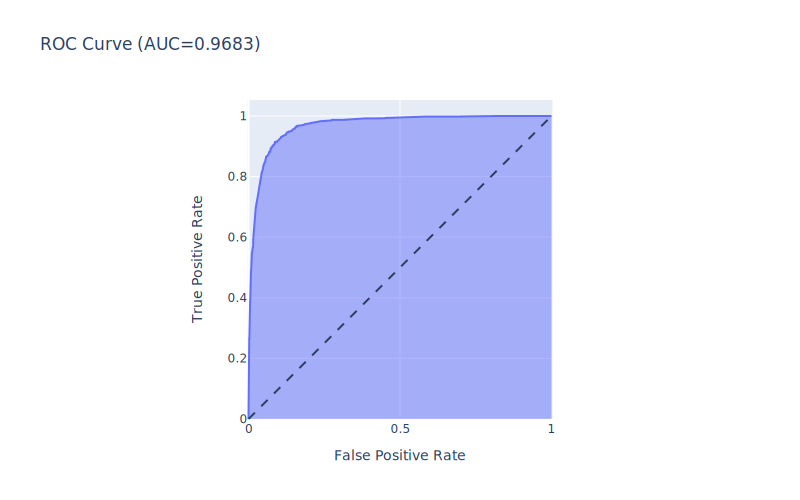

In [25]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [26]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

In [27]:
# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.79, 0.81)]

,fpr,tpr,threshold
152,0.038849,0.792713,0.805119
153,0.039329,0.792713,0.804529
154,0.039329,0.799114,0.798925
155,0.039808,0.799114,0.798722
156,0.039808,0.801083,0.795776
157,0.040288,0.801083,0.795657
158,0.040288,0.804037,0.793519
159,0.040767,0.804037,0.792045
160,0.040767,0.806499,0.790773
161,0.041727,0.806499,0.785370


For this data set also, it is safe to assume the threshold of 0.5.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



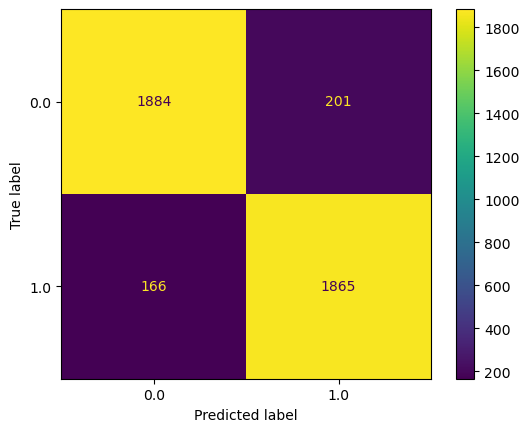

In [28]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_result, X_test, y_test)  

In [29]:
# Save the model
joblib.dump(grid_result, './../../data/models/ann_oversample.pkl')

['./../../data/models/ann_oversample.pkl']